In [ ]:
!pip install nibabel scikit-image ipywidgets plotly
from google.colab import output
output.enable_custom_widget_manager()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.9 MB/s eta 0:00:00


File 'angio.nii' already exists. Proceeding with loading.
Volume shape: (640, 480, 168)


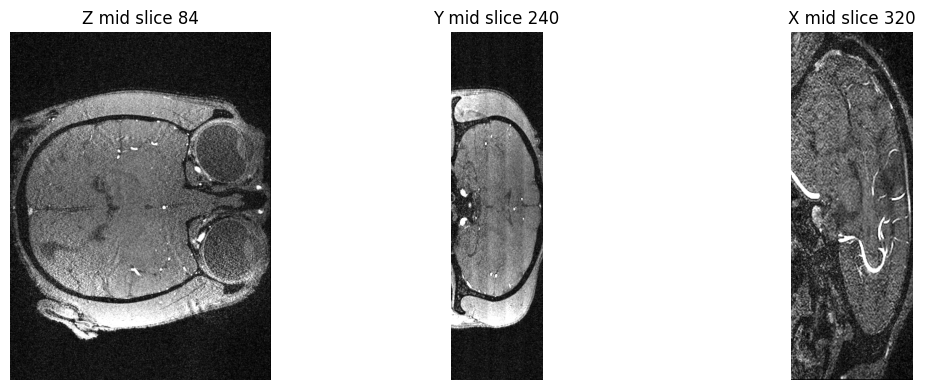

In [ ]:
from google.colab import files
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os


# ---- Define the expected NIfTI filename ----
# We anticipate the file might be named angio.nii or angio.nii.gz
final_filename = "angio.nii"
gzipped_filename_candidate = "angio.nii.gz"


# Logic to handle potentially misnamed NIfTI file
if not os.path.exists(final_filename):
   if os.path.exists(gzipped_filename_candidate):
       try:
           # Try to load as gzip first to confirm it's truly gzipped
           # If this succeeds, then the current filename is fine.
           # If it fails with the specific error, we rename.
           img = nib.load(gzipped_filename_candidate)
           # If it loads without error, then final_filename should be gzipped_filename_candidate
           final_filename = gzipped_filename_candidate
           print(f"File '{final_filename}' found and loaded successfully as gzip (verified). Proceeding with loading.")
       except nib.loadsave.ImageFileError as e: # Corrected exception handling
           if "is not a gzip file" in str(e):
               print(f"File '{gzipped_filename_candidate}' found, but it is not a gzip file. Renaming to '{final_filename}'.")
               os.rename(gzipped_filename_candidate, final_filename)
           else:
               # Re-raise if it's a different ImageFileError
               raise
   else:
       print(f"Required file '{final_filename}' or '{gzipped_filename_candidate}' not found. Please upload it manually or provide its path.")
       raise FileNotFoundError(f"Required file '{final_filename}' or '{gzipped_filename_candidate}' not found. Please upload it manually or provide its path.")
else:
   print(f"File '{final_filename}' already exists. Proceeding with loading.")


# 3) Load the NIfTI volume
# If we reached here, final_filename should be correct (either angio.nii or angio.nii.gz)
img = nib.load(final_filename)
volume = img.get_fdata()  # This is a 3D numpy array (x, y, z)
print("Volume shape:", volume.shape)


# Optional: normalize intensities to [0, 1]
volume = volume.astype(np.float32)
v_min, v_max = np.percentile(volume, [1, 99])  # robust range
volume = np.clip((volume - v_min) / (v_max - v_min + 1e-8), 0, 1)


# Show a few slices to verify it looks right
mid_z = volume.shape[2] // 2
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(volume[:,:,mid_z], cmap='gray')
plt.title(f'Z mid slice {mid_z}')
plt.axis('off')


mid_y = volume.shape[1] // 2
plt.subplot(1,3,2)
plt.imshow(volume[:,mid_y,:], cmap='gray')
plt.title(f'Y mid slice {mid_y}')
plt.axis('off')


mid_x = volume.shape[0] // 2
plt.subplot(1,3,3)
plt.imshow(volume[mid_x,:,:], cmap='gray')
plt.title(f'X mid slice {mid_x}')
plt.axis('off')


plt.tight_layout()
plt.show()


Full volume shape: (640, 480, 168)
Cropped shape: (320, 240, 101)
Downsampled shape: (107, 80, 51)
Running Frangi on small volume...
Done. Frangi stats: min = 0.0 max = 0.00021001779522087822


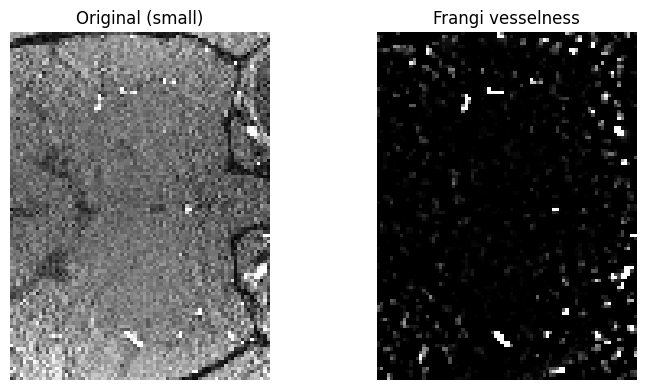

Threshold value (percentile 90): 6.882908744138592e-07
Mask - voxels before cleanup: 43656
Mask - voxels after  cleanup: 22978


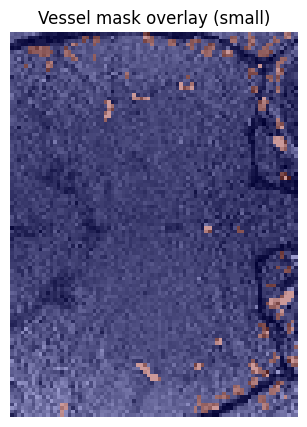

Running marching cubes on small mask...
Vertices: (64215, 3)
Faces: (129668, 3)


In [ ]:
import numpy as np
from skimage.filters import frangi
from skimage import morphology
from skimage.measure import marching_cubes
import matplotlib.pyplot as plt
import plotly.graph_objects as go

#Openai assistance for some of the code below
#CROP + DOWNSAMPLE
sx, sy, sz = volume.shape
print("Full volume shape:", volume.shape)


#take central 50% region in x & y, and middle 60% in z
x0, x1 = sx//4, 3*sx//4
y0, y1 = sy//4, 3*sy//4
z0, z1 = int(sz*0.2), int(sz*0.8)


vol_crop = volume[x0:x1, y0:y1, z0:z1]
print("Cropped shape:", vol_crop.shape)


#strong downsampling: every 3 voxels in x,y and every 2 in z
vol_small = vol_crop[::3, ::3, ::2]
print("Downsampled shape:", vol_small.shape)


#FRANGI ON SMALL VOLUME
print("Running Frangi on small volume...")


vesselness = frangi(
   vol_small,
   sigmas=(1, 2),      # fewer scales = faster
   alpha=0.5,
   beta=0.5,
   gamma=15,
   black_ridges=False
)


print("Done. Frangi stats:",
     "min =", float(vesselness.min()),
     "max =", float(vesselness.max()))


# Show original vs Frangi
z_small = vol_small.shape[2] // 2


fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].imshow(vol_small[:, :, z_small], cmap='gray')
axes[0].set_title("Original (small)")
axes[0].axis('off')


v_slice = vesselness[:, :, z_small]
vmin, vmax = np.percentile(v_slice, [1, 99])
axes[1].imshow(v_slice, cmap='gray', vmin=vmin, vmax=vmax)
axes[1].set_title("Frangi vesselness")
axes[1].axis('off')


plt.tight_layout()
plt.show()


#SEGMENTATION/THRESHOLDING
percentile_thresh = 90
T = np.percentile(vesselness, percentile_thresh)
print(f"Threshold value (percentile {percentile_thresh}):", float(T))


vessel_mask = vesselness > T


#remove noise
min_size = 50
vessel_mask_clean = morphology.remove_small_objects(vessel_mask, min_size=min_size)


print("Mask - voxels before cleanup:", int(vessel_mask.sum()))
print("Mask - voxels after  cleanup:", int(vessel_mask_clean.sum()))


# Overlay on slice
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.imshow(vol_small[:, :, z_small], cmap='gray')
ax.imshow(vessel_mask_clean[:, :, z_small], cmap='jet', alpha=0.4)
ax.set_title("Vessel mask overlay (small)")
ax.axis('off')
plt.show()


#3D MESH ON SMALL MASK
print("Running marching cubes on small mask...")
verts, faces, normals, values = marching_cubes(
   vessel_mask_clean.astype(np.uint8),
   level=0.5,
   step_size=1
)


print("Vertices:", verts.shape)
print("Faces:", faces.shape)


x, y, z = verts.T


mesh = go.Mesh3d(
   x=x, y=y, z=z,
   i=faces[:,0],
   j=faces[:,1],
   k=faces[:,2],
   opacity=0.4,
   color='red'
)


fig = go.Figure(data=[mesh])
fig.update_layout(
   title="3D Brain Vessel Reconstruction (cropped & downsampled)",
   scene=dict(
       xaxis_title="X",
       yaxis_title="Y",
       zaxis_title="Z",
       aspectmode="data"
   )
)
fig.show()


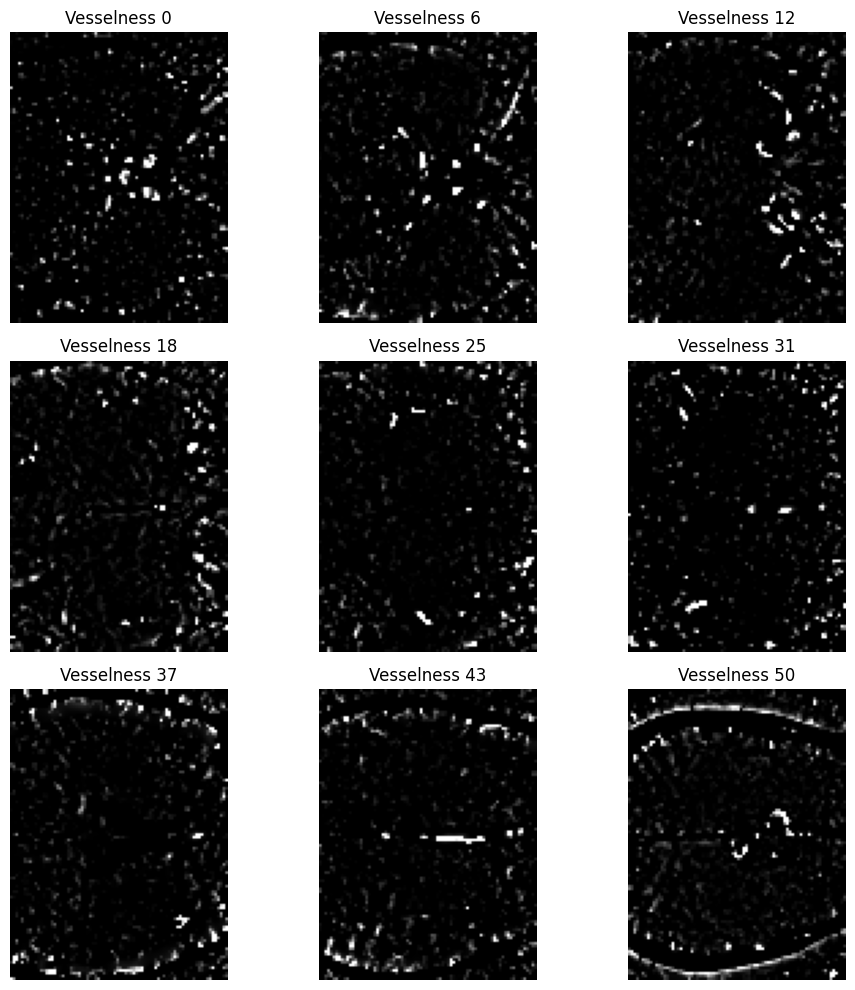

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(10,10))
slices = np.linspace(0, vesselness.shape[2]-1, 9).astype(int)

for ax, idx in zip(axes.flat, slices):
    vsl = vesselness[:, :, idx]
    vmin, vmax = np.percentile(vsl, [1, 99])
    ax.imshow(vsl, cmap='gray', vmin=vmin, vmax=vmax)
    ax.set_title(f"Vesselness {idx}")
    ax.axis("off")

plt.tight_layout()
plt.savefig("figure3_frangi_grid.png", dpi=300)
plt.show()
